# Integrated Gradients Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:400%; margin-right:auto; margin-left:0;"
opt.columnDefs = [{"className": "dt-left", "targets": "_all"}]
opt.classes = 'display'
opt.dom = "lti"
opt.column_filters = "footer"
opt.lengthMenu = list(range(3, 250, 50))

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
from tqdm.notebook import tqdm

from captum.attr import LayerIntegratedGradients
from captum.attr import visualization as viz

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from ig_utils import *
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_ig = config["path_ig"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

Parameter  \
0                 path_ttc4900   
1                 path_tr_news   
2              path_interpress   
3                    path_tc32   
4      path_bert_model_ttc4900   
5      path_bert_model_tr_news   
6   path_bert_model_interpress   
7         path_bert_model_tc32   
8       path_tbt_model_ttc4900   
9       path_tbt_model_tr_news   
10   path_tbt_model_interpress   
11         path_tbt_model_tc32   
12                   path_shap   
13                   path_lime   
14                     path_ig   
15                   path_rand   
16              path_attention   
17                path_reports   
18                  thresholds   
19                   only_load   
20                      device   
21         pipeline_parameters   

                                                               Value  
0                                                     Data/TTC_4900/  
1                                                      Data/TR_News/  
2                                                   Data/Interpress/  
3                                                         Data/TC32/  
4              Models/berturk_text_classification_fine_tuned_ttc4900  
5              Models/berturk_text_classification_fine_tuned_tr_news  
6           Models/berturk_text_classification_fine_tuned_interpress  
7                 Models/berturk_text_classification_fine_tuned_tc32  
8      Models/turkishbertweet_text_classification_fine_tuned_ttc4900  
9      Models/turkishbertweet_text_classification_fine_tuned_tr_news  
10  Models/turkishbertweet_text_classification_fine_tuned_interpress  
11        Models/turkishbertweet_text_classification_fine_tuned_tc32  
12                                                    Data/Exp_SHAP/  
13                                                    Data/Exp_LIME/  
14                                                      Data/Exp_IG/  
15                                                    Data/Exp_Rand/  
16                                               Data/Exp_Attention/  
17                                                          Reports/  
18                                                   [0.5, 0.6, 0.7]  
19                                                              True  
20                                                              cuda  
21   {'padding': 'max_length', 'truncation': True, 'batch_size': 16}

## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## Integrated Gradients Explainability

In [4]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTurk

#### Inference on Full Text

In [5]:
# Load BERTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'berturk_text_classification_fine_tuned_ttc4900' is loaded.

'berturk_text_classification_fine_tuned_tr_news' is loaded.

'berturk_text_classification_fine_tuned_interpress' is loaded.

'berturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
path_classification_results = "Data/Classification_Results/BERTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [7]:
num_samples = 250

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [8]:
model_ttc4900_output = create_model_output_function(bert_model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, bert_model_ttc4900.bert.embeddings)

ttc4900_bert_results = {}

for threshold in thresholds:
    
    ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                            ttc4900_test, 
                                            lig_ttc4900, 
                                            bert_model_ttc4900, bert_tokenizer_ttc4900, 
                                            f"ig_and_scores_ttc_{threshold}_bert",
                                            device,
                                            only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, threshold)
    
    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (score_vis_ttc, ttc4900_bert_result)
    
    clear_gpu_memory()
    
show(ttc4900_bert_results[0.5][1])

'ig_and_scores_ttc_0.5_bert' file length: 250


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


'ig_and_scores_ttc_0.6_bert' file length: 250
'ig_and_scores_ttc_0.7_bert' file length: 250


In [9]:
# sample_no = 28

# viz.visualize_text([ttc4900_bert_results[0.6][0][sample_no]])
# viz.visualize_text([ttc4900_bert_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.864
Overall Relative Change (ORC) positive changes      :  2.558 %
Overall Relative Change (ORC) negative changes      : -15.281 %


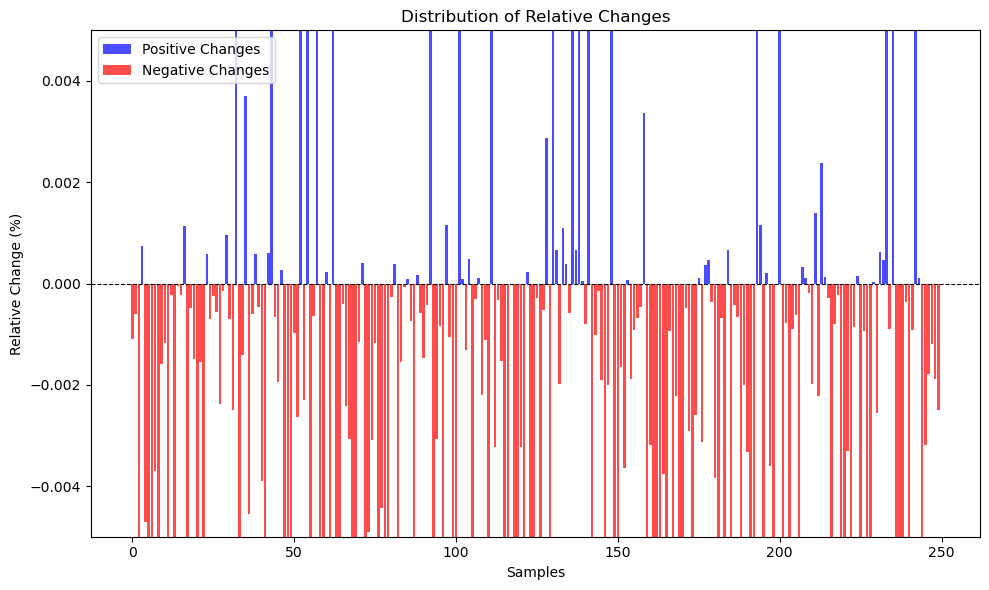


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.863
Overall Relative Change (ORC) positive changes      :  2.5 %
Overall Relative Change (ORC) negative changes      : -15.743 %


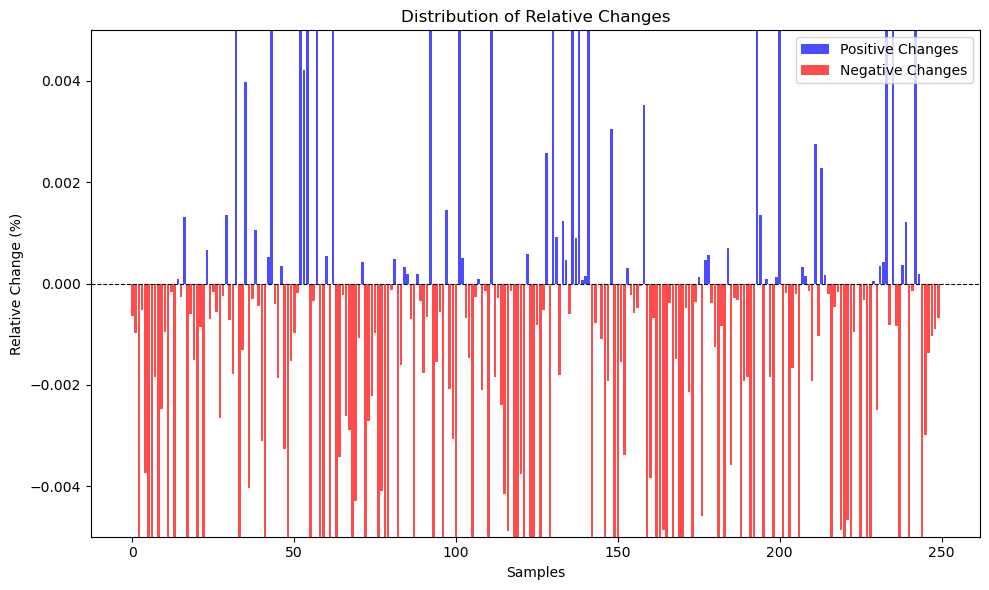


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.864
Overall Relative Change (ORC) positive changes      :  2.22 %
Overall Relative Change (ORC) negative changes      : -16.347 %


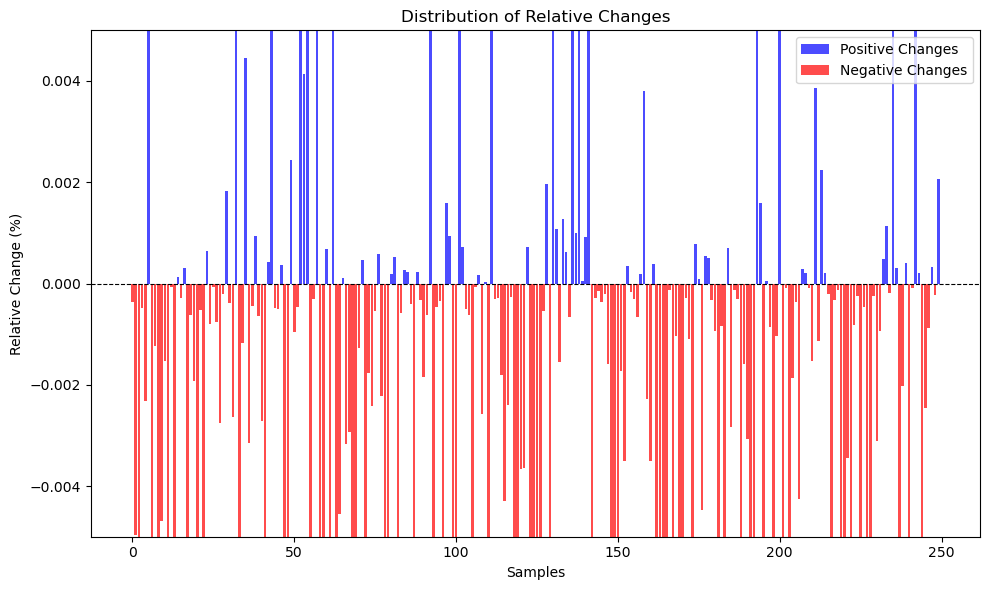

In [10]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [11]:
model_tr_news_output = create_model_output_function(bert_model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, bert_model_tr_news.bert.embeddings)

tr_news_bert_results = {}

for threshold in thresholds:

    ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                    tr_news_test, 
                                                    lig_tr_news, 
                                                    bert_model_tr_news, bert_tokenizer_tr_news, 
                                                    f"ig_and_scores_tr_news_{threshold}_bert",
                                                    device, 
                                                    only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(ig_values_tr_news, threshold)
    
    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (score_vis_tr_news, tr_news_bert_result)
    
    clear_gpu_memory()
    
show(tr_news_bert_results[0.5][1])

'ig_and_scores_tr_news_0.5_bert' file length: 250
'ig_and_scores_tr_news_0.6_bert' file length: 250
'ig_and_scores_tr_news_0.7_bert' file length: 250


In [12]:
# sample_no = 33

# viz.visualize_text([tr_news_bert_results[0.6][0][sample_no]])
# viz.visualize_text([tr_news_bert_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.636
Overall Relative Change (ORC) positive changes      :  8.967 %
Overall Relative Change (ORC) negative changes      : -28.761 %


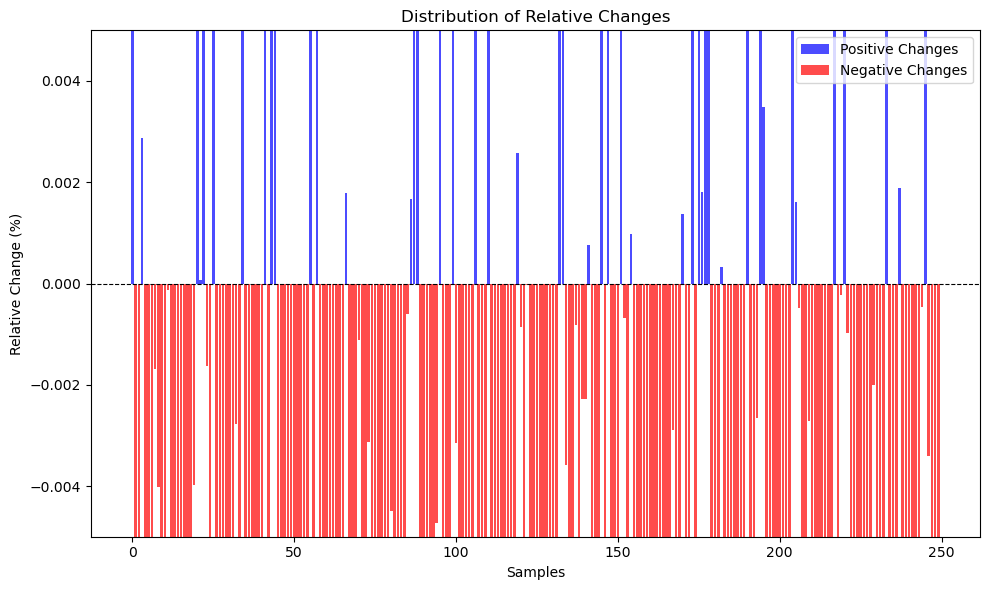


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.661
Overall Relative Change (ORC) positive changes      :  8.069 %
Overall Relative Change (ORC) negative changes      : -26.122 %


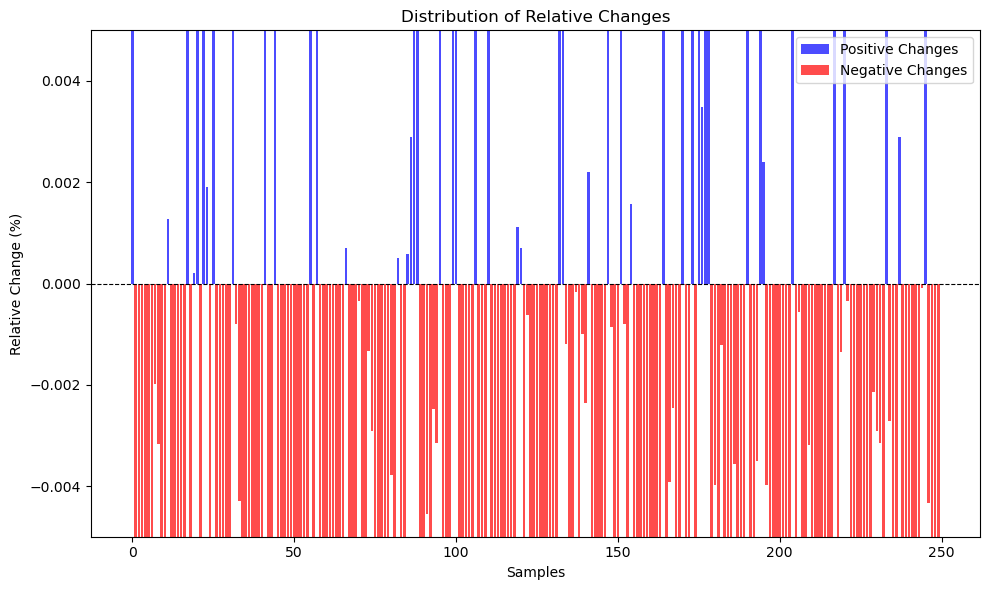


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.688
Overall Relative Change (ORC) positive changes      :  7.014 %
Overall Relative Change (ORC) negative changes      : -24.166 %


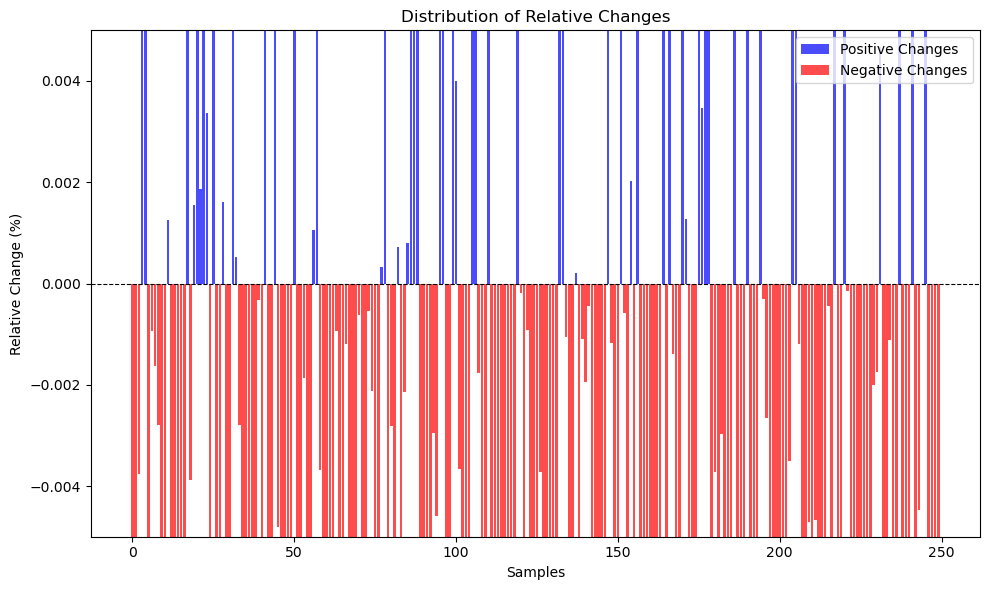

In [13]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [14]:
model_interpress_output = create_model_output_function(bert_model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, bert_model_interpress.bert.embeddings)

interpress_bert_results = {}

for threshold in thresholds:

    ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                          interpress_test, 
                                                          lig_interpress, 
                                                          bert_model_interpress, bert_tokenizer_interpress, 
                                                          f"ig_and_scores_interpress_{threshold}_bert",
                                                          device, 
                                                          only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(ig_values_interpress, threshold)
    
    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (score_vis_interpress, interpress_bert_result)
    
    clear_gpu_memory()
    
show(interpress_bert_results[0.5][1])

'ig_and_scores_interpress_0.5_bert' file length: 250
'ig_and_scores_interpress_0.6_bert' file length: 250
'ig_and_scores_interpress_0.7_bert' file length: 250


In [15]:
# sample_no = 21

# viz.visualize_text([interpress_bert_results[0.6][0][sample_no]])
# viz.visualize_text([interpress_bert_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.788
Overall Relative Change (ORC) positive changes      :  5.449 %
Overall Relative Change (ORC) negative changes      : -25.797 %


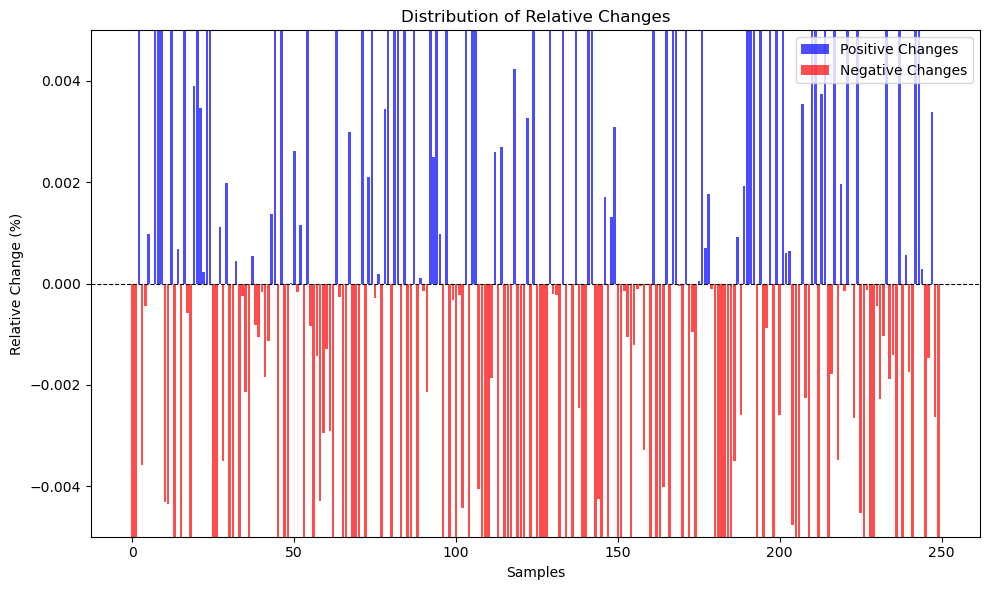


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.806
Overall Relative Change (ORC) positive changes      :  5.201 %
Overall Relative Change (ORC) negative changes      : -25.483 %


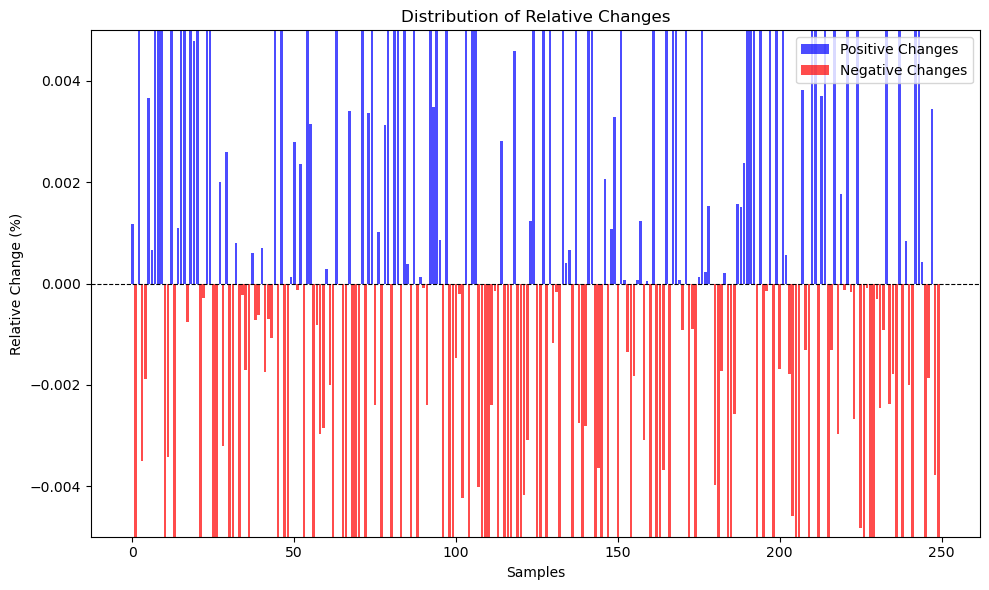


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.826
Overall Relative Change (ORC) positive changes      :  5.618 %
Overall Relative Change (ORC) negative changes      : -22.975 %


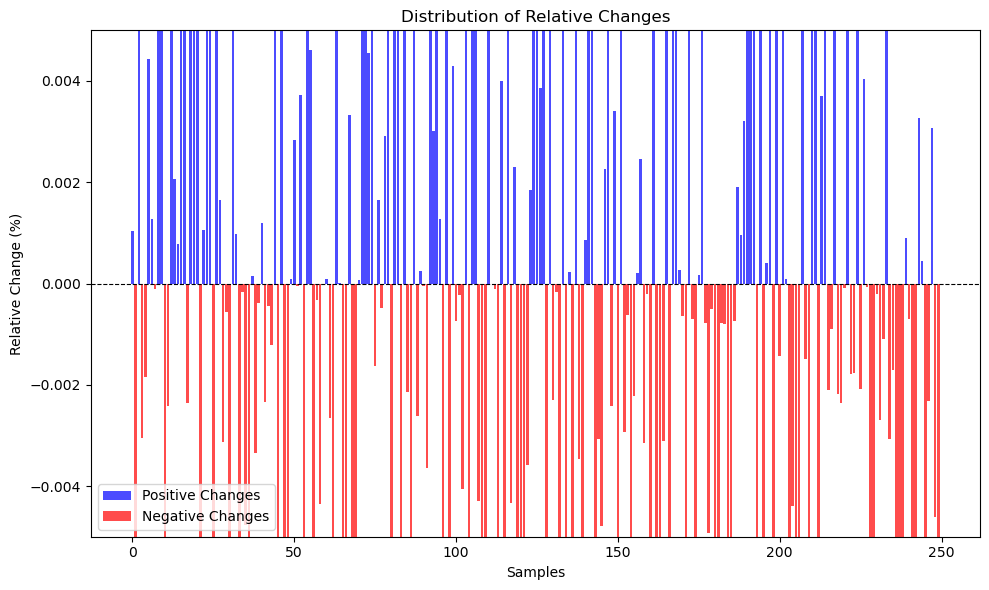

In [16]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC 32

In [17]:
model_tc32_output = create_model_output_function(bert_model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, bert_model_tc32.bert.embeddings)

tc32_bert_results = {}

for threshold in thresholds:

    ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                              tc32_test, 
                                              lig_tc32, 
                                              bert_model_tc32, bert_tokenizer_tc32, 
                                              f"ig_and_scores_tc32_{threshold}_bert",
                                              device,
                                              only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(ig_values_tc32, threshold)
    
    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (score_vis_tc32, tc32_bert_result)
    
    clear_gpu_memory()
    
show(tc32_bert_results[0.5][1])

'ig_and_scores_tc32_0.5_bert' file length: 250
'ig_and_scores_tc32_0.6_bert' file length: 250
'ig_and_scores_tc32_0.7_bert' file length: 250


In [18]:
# sample_no = 41

# viz.visualize_text([tc32_bert_results[0.6][0][sample_no]])
# viz.visualize_text([tc32_bert_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.726
Overall Relative Change (ORC) positive changes      :  0.348 %
Overall Relative Change (ORC) negative changes      : -28.469 %


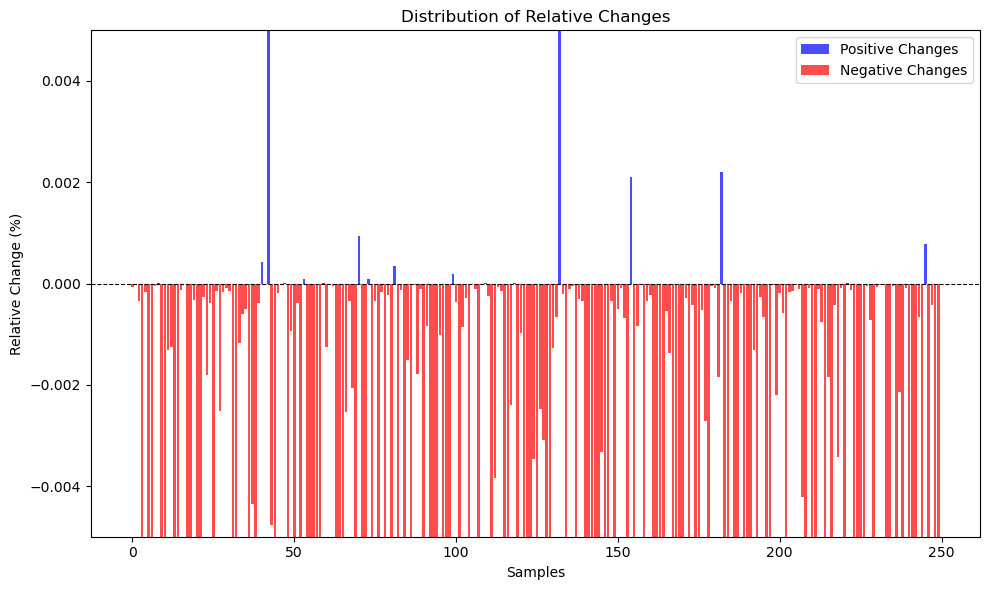


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.761
Overall Relative Change (ORC) positive changes      :  0.31 %
Overall Relative Change (ORC) negative changes      : -24.911 %


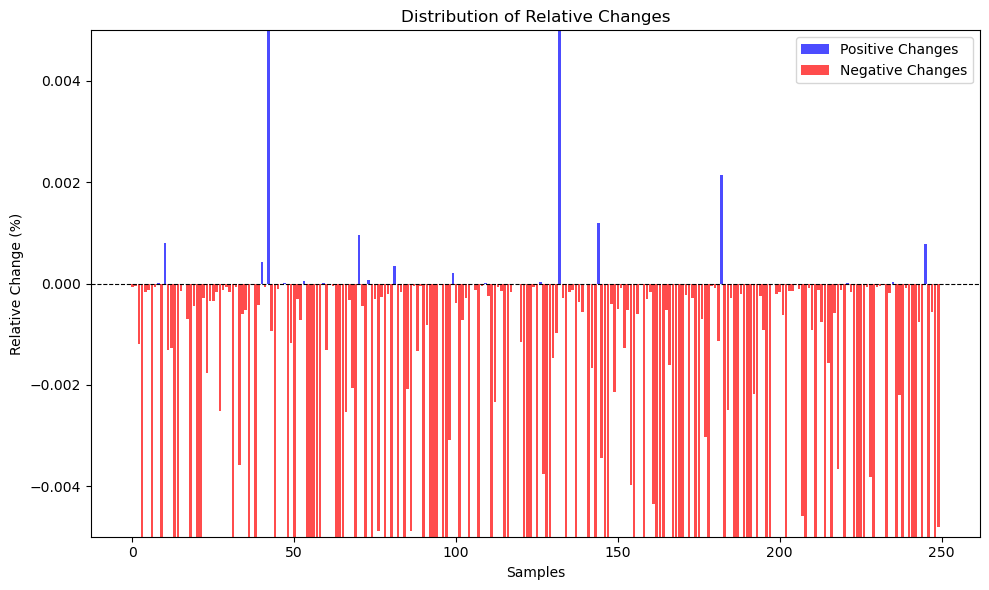


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.768
Overall Relative Change (ORC) positive changes      :  0.17 %
Overall Relative Change (ORC) negative changes      : -24.532 %


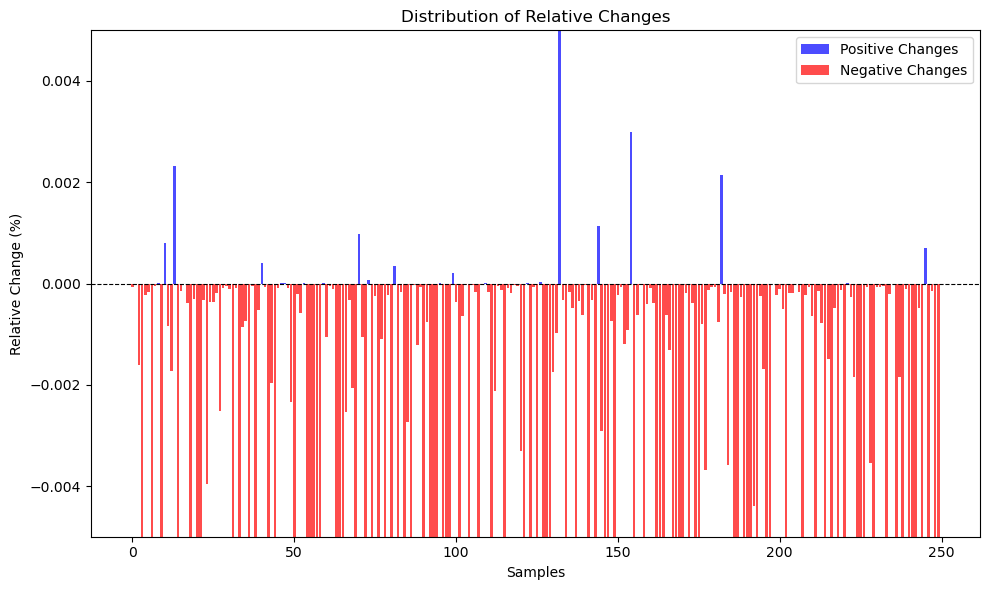

In [19]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [20]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [21]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [22]:
num_samples = 250

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [23]:
model_ttc4900_output = create_model_output_function(tbt_model_ttc4900)
lig_ttc4900 = LayerIntegratedGradients(model_ttc4900_output, tbt_model_ttc4900.roberta.embeddings)

ttc4900_tbt_results = {}

for threshold in thresholds:

    ig_values_ttc, score_vis_ttc = apply_ig(path_ig, 
                                            ttc4900_test, 
                                            lig_ttc4900, 
                                            tbt_model_ttc4900, tbt_tokenizer_ttc4900, 
                                            f"ig_and_scores_ttc_{threshold}_tbt", 
                                            device,
                                            only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(ig_values_ttc, threshold)
    
    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (score_vis_ttc, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
show(ttc4900_tbt_results[0.5][1])

'ig_and_scores_ttc_0.5_tbt' file length: 250
'ig_and_scores_ttc_0.6_tbt' file length: 250
'ig_and_scores_ttc_0.7_tbt' file length: 250


In [24]:
# sample_no = 5

# viz.visualize_text([ttc4900_tbt_results[0.6][0][sample_no]])
# viz.visualize_text([ttc4900_tbt_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.912
Overall Relative Change (ORC) positive changes      :  0.676 %
Overall Relative Change (ORC) negative changes      : -20.294 %


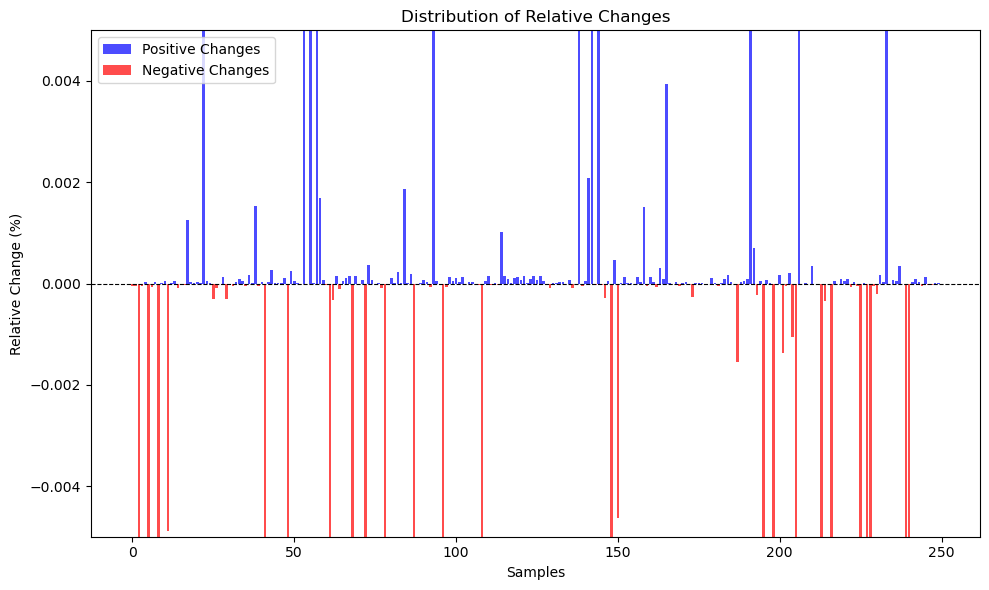


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.912
Overall Relative Change (ORC) positive changes      :  0.695 %
Overall Relative Change (ORC) negative changes      : -18.618 %


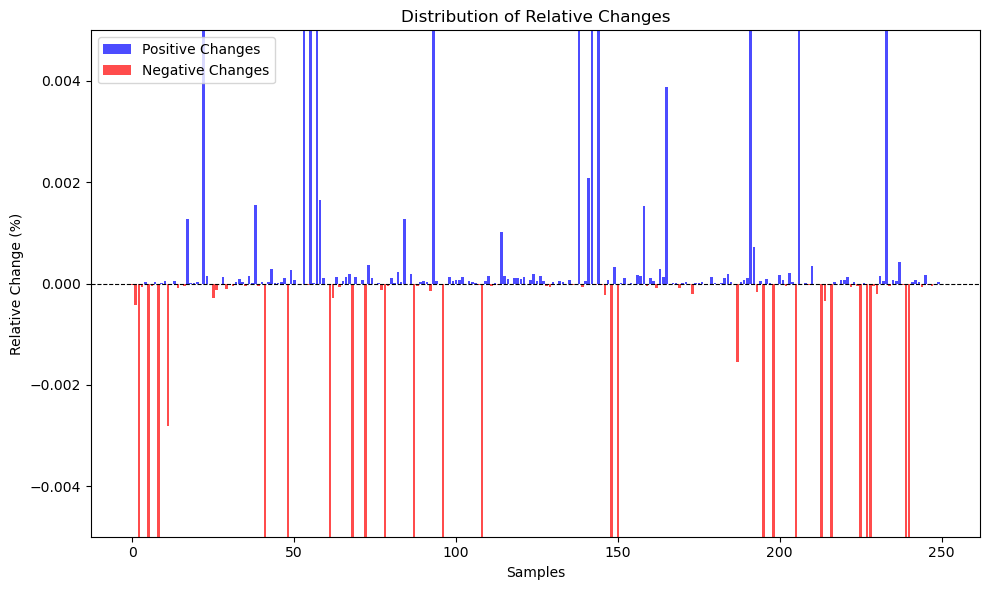


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.913
Overall Relative Change (ORC) positive changes      :  0.566 %
Overall Relative Change (ORC) negative changes      : -18.644 %


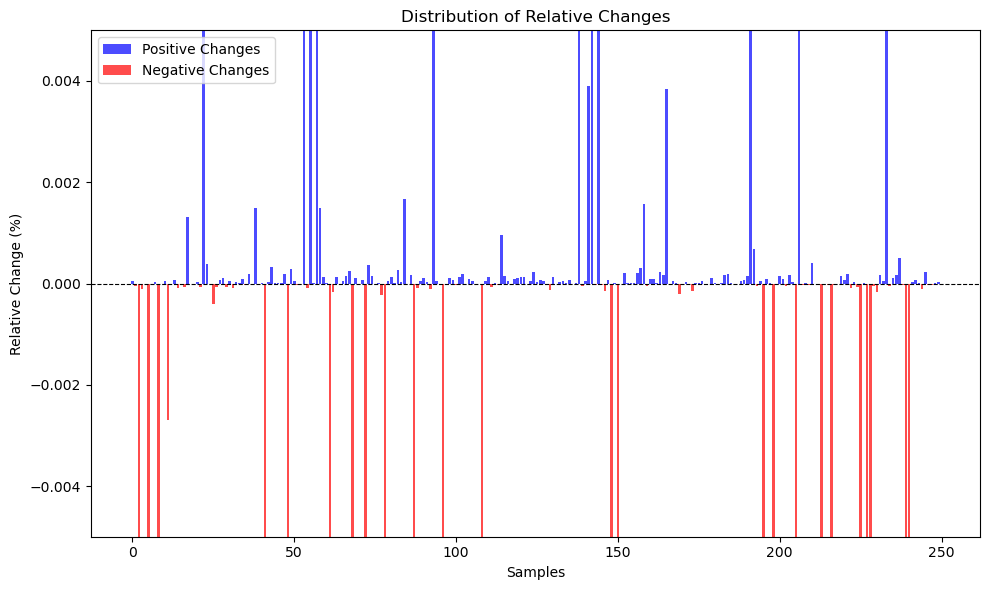

In [25]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [26]:
model_tr_news_output = create_model_output_function(tbt_model_tr_news)
lig_tr_news = LayerIntegratedGradients(model_tr_news_output, tbt_model_tr_news.roberta.embeddings)

tr_news_tbt_results = {}

for threshold in thresholds:

    ig_values_tr_news, score_vis_tr_news = apply_ig(path_ig, 
                                                    tr_news_test, 
                                                    lig_tr_news, 
                                                    tbt_model_tr_news, tbt_tokenizer_tr_news, 
                                                    f"ig_and_scores_tr_news_{threshold}_tbt",
                                                    device, 
                                                    only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(ig_values_tr_news, threshold)
    
    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (score_vis_tr_news, tr_news_tbt_result)
    
    clear_gpu_memory()
    
show(tr_news_tbt_results[0.5][1])

'ig_and_scores_tr_news_0.5_tbt' file length: 250
'ig_and_scores_tr_news_0.6_tbt' file length: 250
'ig_and_scores_tr_news_0.7_tbt' file length: 250


In [27]:
# sample_no = 2

# viz.visualize_text([tr_news_tbt_results[0.6][0][sample_no]])
# viz.visualize_text([tr_news_tbt_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.712
Overall Relative Change (ORC) positive changes      :  5.964 %
Overall Relative Change (ORC) negative changes      : -30.106 %


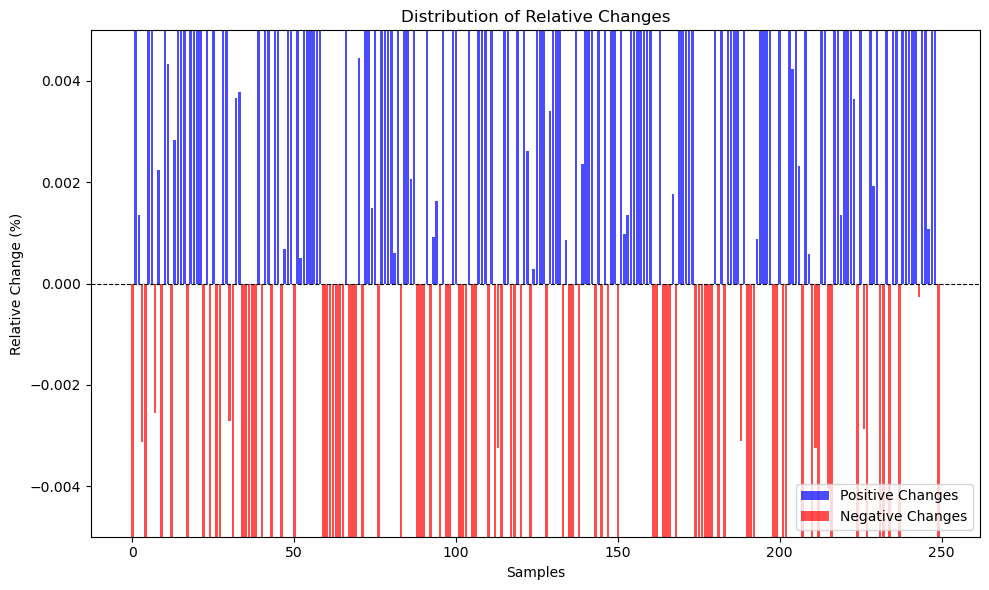


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.713
Overall Relative Change (ORC) positive changes      :  6.774 %
Overall Relative Change (ORC) negative changes      : -31.037 %


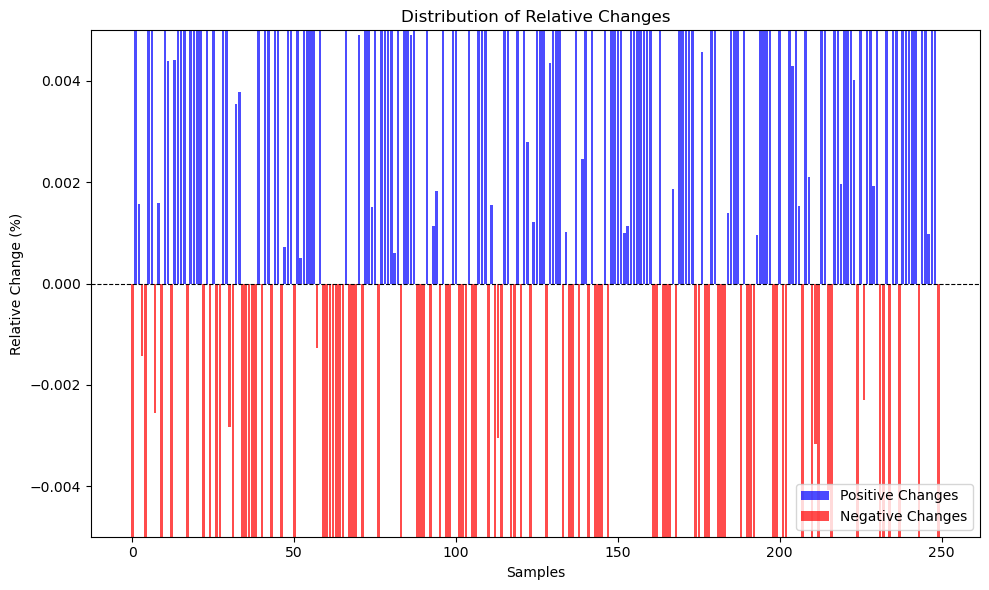


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.714
Overall Relative Change (ORC) positive changes      :  6.944 %
Overall Relative Change (ORC) negative changes      : -31.873 %


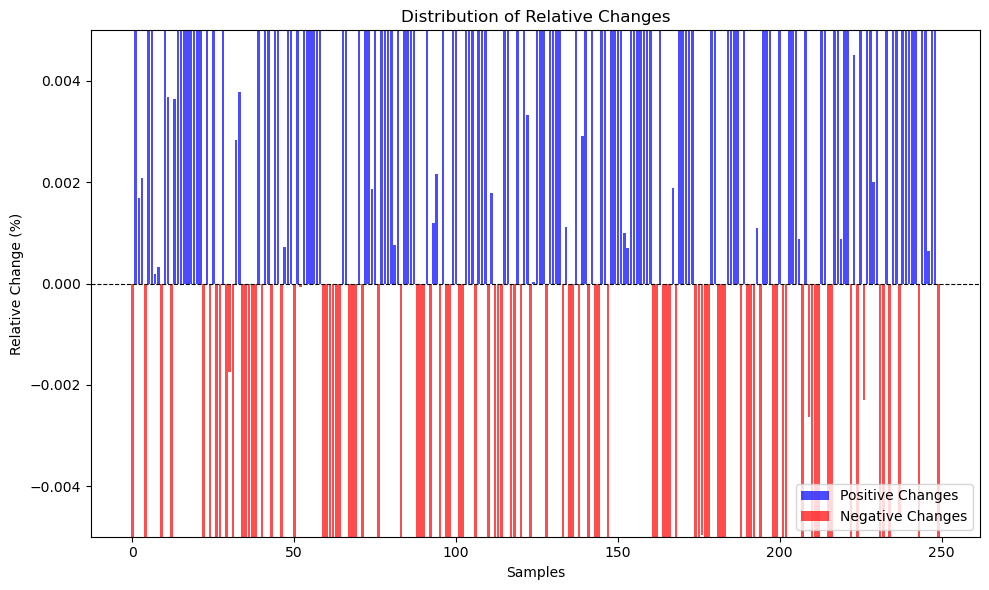

In [28]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [29]:
model_interpress_output = create_model_output_function(tbt_model_interpress)
lig_interpress = LayerIntegratedGradients(model_interpress_output, tbt_model_interpress.roberta.embeddings)

interpress_tbt_results = {}

for threshold in thresholds:

    ig_values_interpress, score_vis_interpress = apply_ig(path_ig, 
                                                          interpress_test, 
                                                          lig_interpress, 
                                                          tbt_model_interpress, tbt_tokenizer_interpress, 
                                                          f"ig_and_scores_interpress_{threshold}_tbt",
                                                          device, 
                                                          only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(ig_values_interpress, threshold)
    
    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (score_vis_interpress, interpress_tbt_result)
    
    clear_gpu_memory()
    
show(interpress_tbt_results[0.5][1])

'ig_and_scores_interpress_0.5_tbt' file length: 250
'ig_and_scores_interpress_0.6_tbt' file length: 250
'ig_and_scores_interpress_0.7_tbt' file length: 250


In [30]:
# sample_no = 10

# viz.visualize_text([interpress_tbt_results[0.6][0][sample_no]])
# viz.visualize_text([interpress_tbt_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.637
Overall Relative Change (ORC) positive changes      :  4.69 %
Overall Relative Change (ORC) negative changes      : -48.386 %


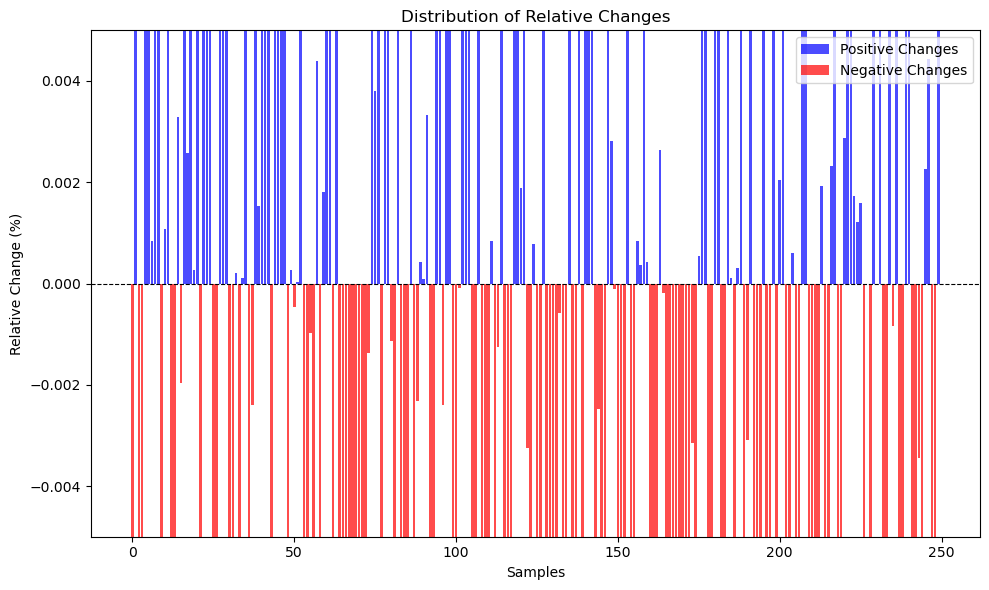


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.667
Overall Relative Change (ORC) positive changes      :  4.896 %
Overall Relative Change (ORC) negative changes      : -45.51 %


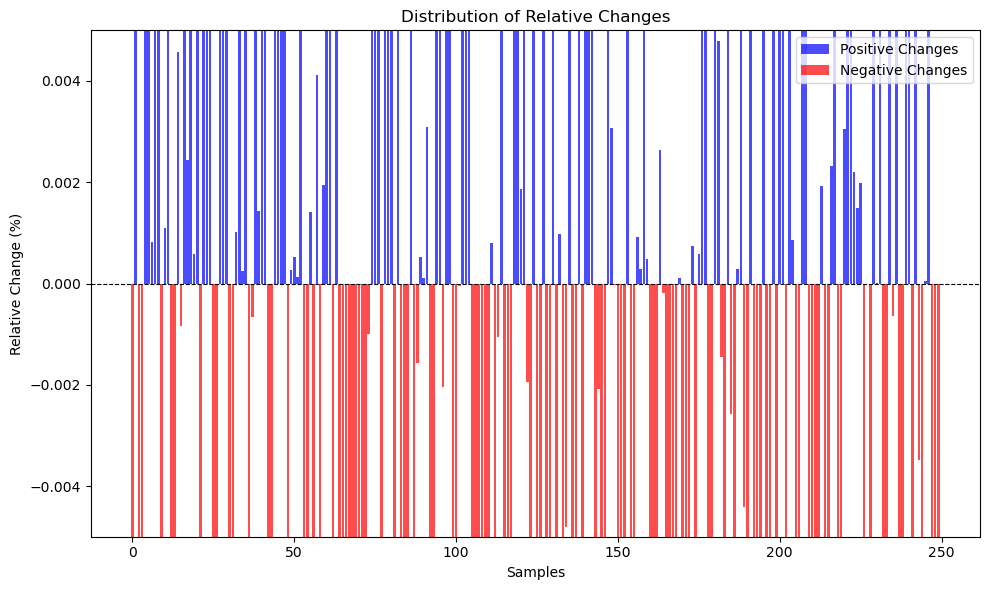


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.696
Overall Relative Change (ORC) positive changes      :  4.91 %
Overall Relative Change (ORC) negative changes      : -42.91 %


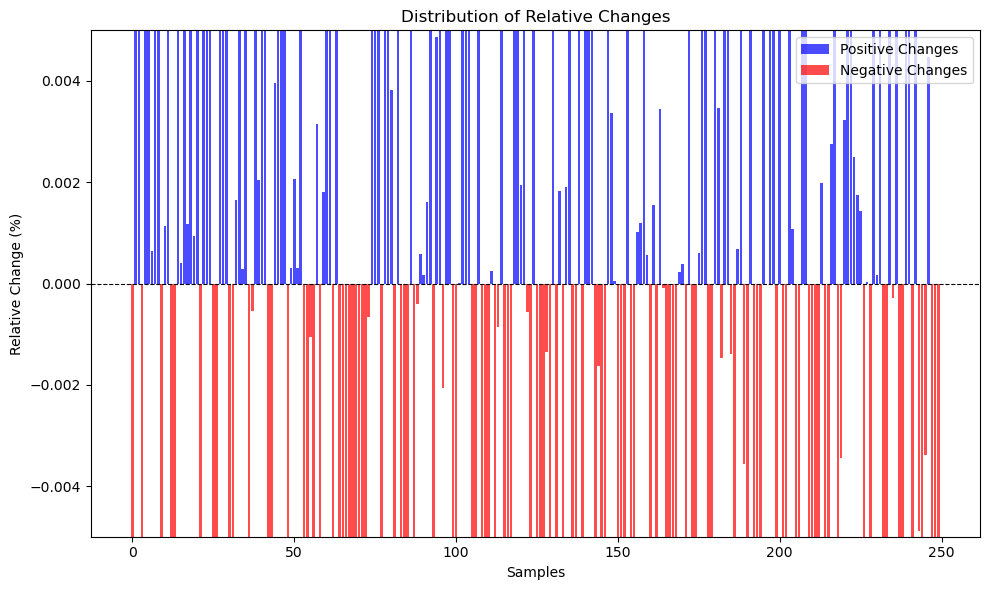

In [31]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [32]:
model_tc32_output = create_model_output_function(tbt_model_tc32)
lig_tc32 = LayerIntegratedGradients(model_tc32_output, tbt_model_tc32.roberta.embeddings)

tc32_tbt_results = {}

for threshold in thresholds:

    ig_values_tc32, score_vis_tc32 = apply_ig(path_ig, 
                                              tc32_test, 
                                              lig_tc32, 
                                              tbt_model_tc32, tbt_tokenizer_tc32, 
                                              f"ig_and_scores_tc32_{threshold}_tbt",
                                              device, 
                                              only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(ig_values_tc32, threshold)
    
    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (score_vis_tc32, tc32_tbt_result)
    
    clear_gpu_memory()
    
show(tc32_tbt_results[0.5][1])

'ig_and_scores_tc32_0.5_tbt' file length: 250
'ig_and_scores_tc32_0.6_tbt' file length: 250
'ig_and_scores_tc32_0.7_tbt' file length: 250


In [33]:
# sample_no = 19

# viz.visualize_text([tc32_tbt_results[0.6][0][sample_no]])
# viz.visualize_text([tc32_tbt_results[0.6][1][sample_no]])
# display()


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.56
Overall Relative Change (ORC) positive changes      :  1.648 %
Overall Relative Change (ORC) negative changes      : -45.268 %


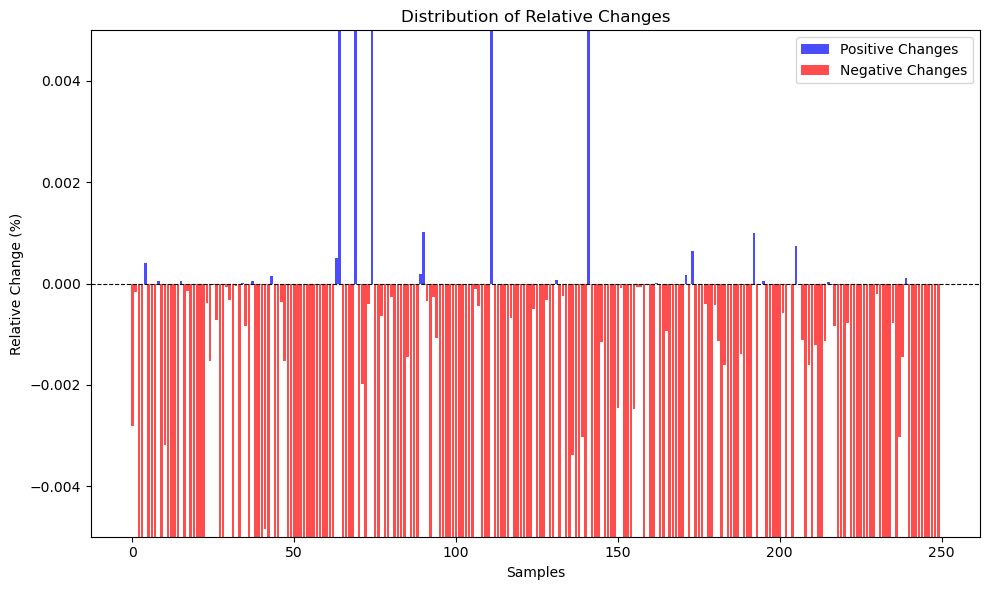


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.601
Overall Relative Change (ORC) positive changes      :  1.464 %
Overall Relative Change (ORC) negative changes      : -41.951 %


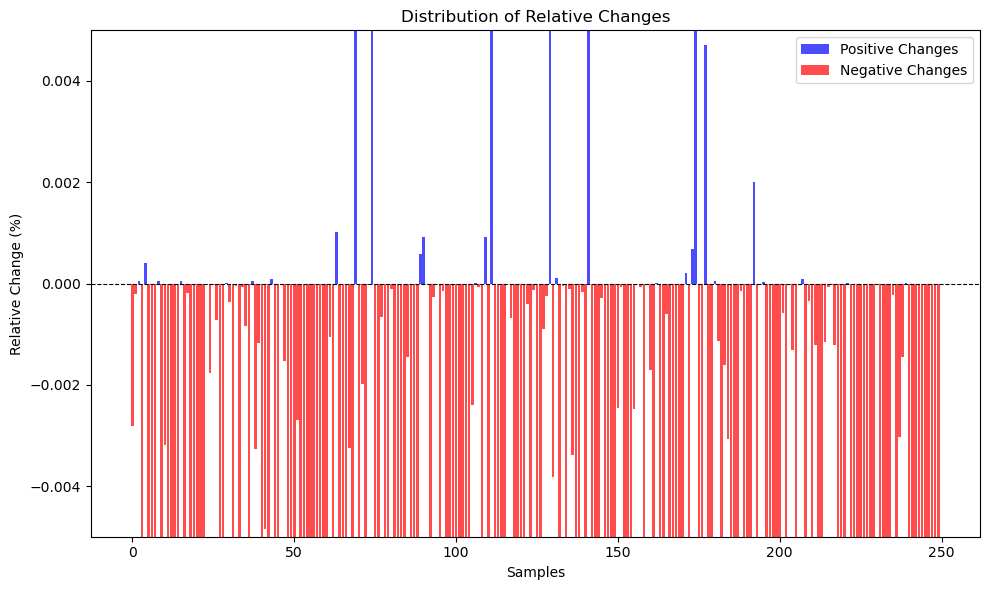


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.733
Overall Relative Change (ORC) positive changes      :  1.61 %
Overall Relative Change (ORC) negative changes      : -28.304 %


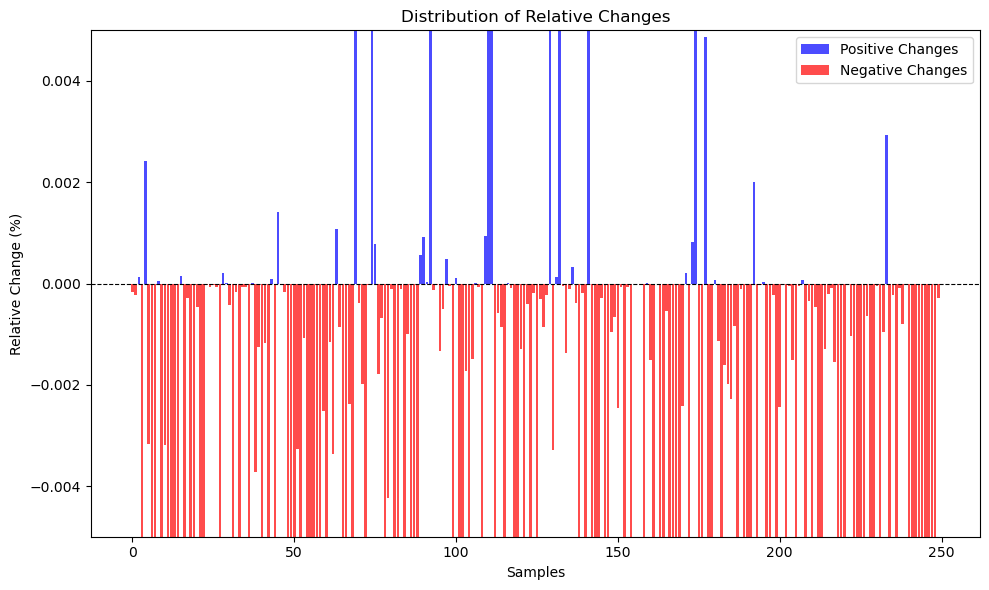

In [34]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [35]:
all_exp_results

Cl Acc  ECS FT  ECS TT  ORC (+)  ORC (-)
0    0.900   0.973   0.864    2.558  -15.281
1    0.900   0.973   0.863    2.500  -15.743
2    0.900   0.973   0.864    2.220  -16.347
3    0.776   0.856   0.636    8.967  -28.761
4    0.776   0.856   0.661    8.069  -26.122
5    0.776   0.856   0.688    7.014  -24.166
6    0.852   0.927   0.788    5.449  -25.797
7    0.852   0.927   0.806    5.201  -25.483
8    0.852   0.927   0.826    5.618  -22.975
9    0.952   0.991   0.726    0.348  -28.469
10   0.952   0.991   0.761    0.310  -24.911
11   0.952   0.991   0.768    0.170  -24.532
12   0.900   0.987   0.912    0.676  -20.294
13   0.900   0.987   0.912    0.695  -18.618
14   0.900   0.987   0.913    0.566  -18.644
15   0.712   0.798   0.712    5.964  -30.106
16   0.712   0.798   0.713    6.774  -31.037
17   0.712   0.798   0.714    6.944  -31.873
18   0.764   0.878   0.637    4.690  -48.386
19   0.764   0.878   0.667    4.896  -45.510
20   0.764   0.878   0.696    4.910  -42.910
21   0.912   0.970   0.560    1.648  -45.268
22   0.912   0.970   0.601    1.464  -41.951
23   0.912   0.970   0.733    1.610  -28.304

In [36]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_exp_results.to_excel(writer, sheet_name='IG', index=False)